#EDA of the merged credit dataset

The merged dataset + the derived target where
high_risk = 1 - (minority class)
high_risk = 0 - (majority class)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

merged = pd.read_csv("../Dataset/merged_credit_data.csv")
print ("Merged shape: ", merged.shape)
merged.head()

Merged shape:  (36457, 30)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,num_missed,num_closed,num_no_loan,max_status,last_status,min_month,max_month,fraction_delinq,risk_score,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,13,1,1.0,X,-15,0,0.0,0.5,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,12,1,1.0,X,-14,0,0.0,0.5,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,7,16,0.0,X,-29,0,0.0,0.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,0,3,0.0,X,-4,0,0.0,0.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,0,5,0.0,X,-26,-22,0.0,0.0,0


In [2]:
#Checking which columns are numeric vs categoircal
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

Class counts:  high_risk
0    36074
1      383
Name: count, dtype: int64
Class proportions:  high_risk
0    0.989494
1    0.010506
Name: proportion, dtype: float64


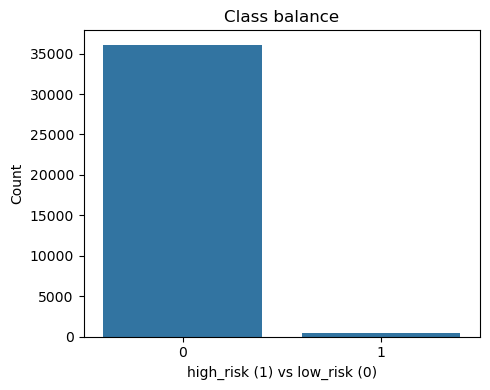

In [3]:
# Checking the number of high vs low risk. Essentially checking for class imbalance
# Output shows the target is extremely imbalanced so accuracy becomes misleading. We have to worry about precision,recall, F1.
# SVM will have to use class weighting
counts = merged["high_risk"].value_counts()
props = merged["high_risk"].value_counts(normalize=True)

print("Class counts: ",counts)
print("Class proportions: ", props)

plt.figure(figsize=(5,4))
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("high_risk (1) vs low_risk (0)")
plt.ylabel("Count")
plt.title("Class balance")
plt.tight_layout()
plt.show()

In [4]:
#Check missing to see what should be dropped
missing = merged.isna().sum().sort_values(ascending=False)
missing_pct = (missing/len(merged) *100).round(2)

missing_table = pd.DataFrame({
    "missing_count": missing,
    "missing_percent": missing_pct
})

missing_table.head(20)


,missing_count,missing_percent
OCCUPATION_TYPE,11323,31.06
ID,0,0.00
FLAG_OWN_CAR,0,0.00
FLAG_OWN_REALTY,0,0.00
CNT_CHILDREN,0,0.00
CODE_GENDER,0,0.00
NAME_INCOME_TYPE,0,0.00
NAME_EDUCATION_TYPE,0,0.00
NAME_FAMILY_STATUS,0,0.00
NAME_HOUSING_TYPE,0,0.00


In [5]:
#Using same categorical and numeric columns
numeric_subset = [c for c in ["AMT_INCOME_TOTAL","DAYS_EMPLOYED","DAYS_BIRTH","CNT_FAM_MEMBERS"] if c in merged.columns]
possible_cats = ["OCCUPATION_TYPE","FLAG_MOBIL","CODE_GENDER",
                 "NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]
categorical_cols = [c for c in possible_cats if c in merged.columns]

print("Numeric subset:", numeric_subset)
print("Categorical cols:", categorical_cols)


Numeric subset: ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'CNT_FAM_MEMBERS']
Categorical cols: ['OCCUPATION_TYPE', 'FLAG_MOBIL', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']


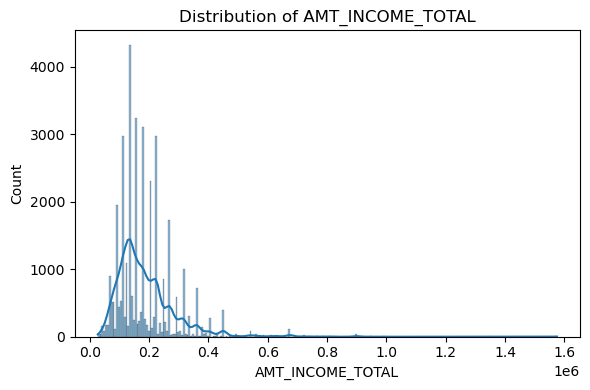

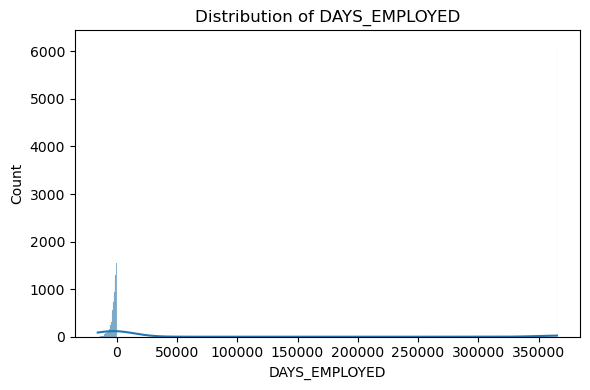

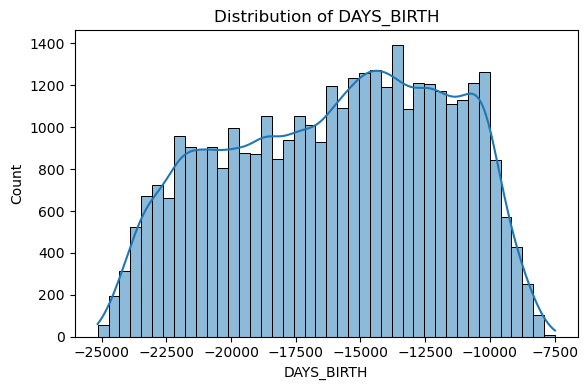

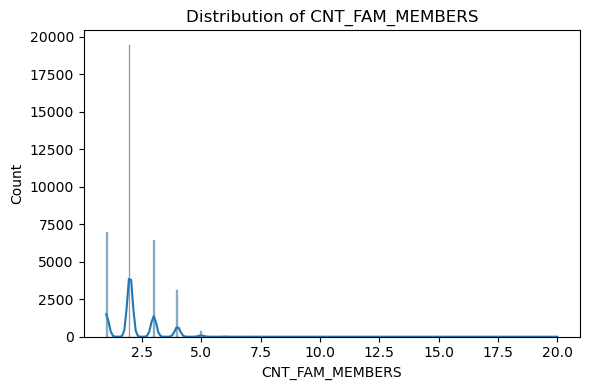

In [6]:
#Checking numeric columns for any outliers
for col in numeric_subset:
    plt.figure(figsize=(6,4))
    sns.histplot(merged[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


In [7]:
#First remove the DAYS_EMPLOYED = 365243. This is the number used for when employment length is unknown, so we should treat it as missing
#Also, since DAYS_BIRTH, and DAYS_EMPLOYED are kept as negatrive numbers, I convert them here to years so its easier to report on and understand

eda = merged.copy()
if "DAYS_EMPLOYED" in merged.columns:
    outlier_count = (merged["DAYS_EMPLOYED"] == 365243).sum()
    print("DAYS_EMPLOYED outlier (365243) count:", outlier_count, f"({outlier_count/len(merged):.2%} of rows)")

# Create interpretable versions
eda = merged.copy()
if "DAYS_BIRTH" in eda.columns:
    eda["AGE_YEARS"] = (-eda["DAYS_BIRTH"] / 365.25)

if "DAYS_EMPLOYED" in eda.columns:
    # treat outlier as missing for EDA
    eda.loc[eda["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan
    eda["EMPLOYED_YEARS"] = (-eda["DAYS_EMPLOYED"] / 365.25)

eda[["AGE_YEARS","EMPLOYED_YEARS"]].describe()

DAYS_EMPLOYED outlier (365243) count: 6135 (16.83% of rows)


,AGE_YEARS,EMPLOYED_YEARS
count,36457.000000,30322.000000
mean,43.737641,7.242994
std,11.500479,6.454230
min,20.503765,0.046543
25%,34.119097,2.677618
50%,42.609172,5.453799
75%,53.218344,9.596167
max,68.862423,43.019849


Numeric columns used for comparison: ['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AGE_YEARS', 'EMPLOYED_YEARS']


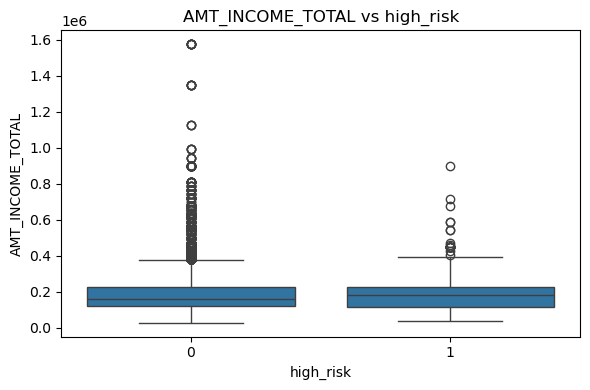

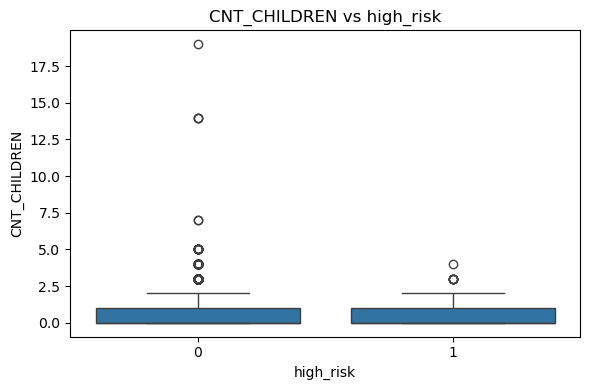

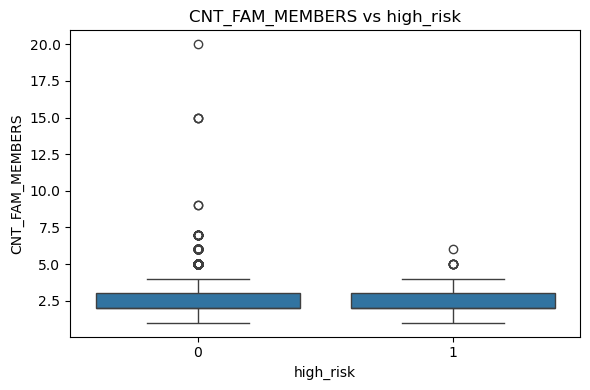

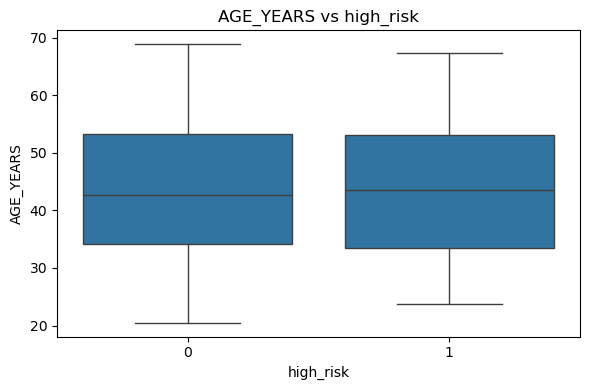

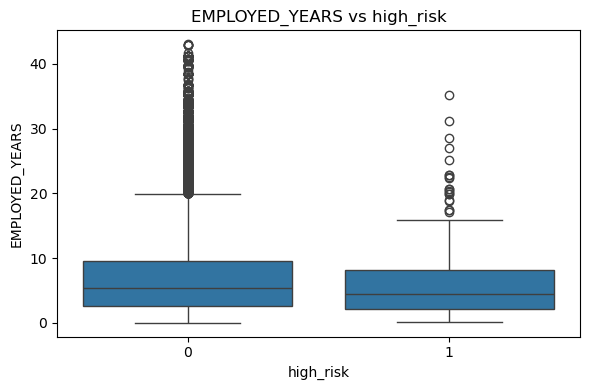

In [8]:
num_for_compare = []
for c in ["AMT_INCOME_TOTAL","CNT_CHILDREN","CNT_FAM_MEMBERS","AGE_YEARS","EMPLOYED_YEARS"]:
    if c in eda.columns:
        num_for_compare.append(c)

print("Numeric columns used for comparison:", num_for_compare)

#boxplots for each numeric column against high risk label
#Will show us any outliers to help standardise the features
for col in num_for_compare:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="high_risk", y=col, data=eda)
    plt.title(f"{col} vs high_risk")
    plt.tight_layout()
    plt.show()

In [9]:
# Use your Abdullahs categorical columns to look at most common categories
try:
    categorical_cols
except NameError:
    possible_cats = ['OCCUPATION_TYPE','FLAG_MOBIL','CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
    categorical_cols = [c for c in possible_cats if c in merged.columns]

print("Categorical columns:", categorical_cols)

for col in categorical_cols:
    print("\n=== ", col, "===")
    print("Top categories by count:")
    print(merged[col].value_counts(dropna=False).head(10))

Categorical columns: ['OCCUPATION_TYPE', 'FLAG_MOBIL', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

===  OCCUPATION_TYPE ===
Top categories by count:
OCCUPATION_TYPE
NaN                      11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Name: count, dtype: int64

===  FLAG_MOBIL ===
Top categories by count:
FLAG_MOBIL
1    36457
Name: count, dtype: int64

===  CODE_GENDER ===
Top categories by count:
CODE_GENDER
F    24430
M    12027
Name: count, dtype: int64

===  NAME_EDUCATION_TYPE ===
Top categories by count:
NAME_EDUCATION_TYPE
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree              


Top OCCUPATION_TYPE categories by high-risk rate (min count=200):


,mean,count
OCCUPATION_TYPE,,
Security staff,0.016892,592
Core staff,0.015595,3591
Cooking staff,0.012214,655
Accountants,0.012087,1241
High skill tech staff,0.009400,1383
Laborers,0.009338,6211
Managers,0.008964,3012
Sales staff,0.008895,3485
Drivers,0.008887,2138


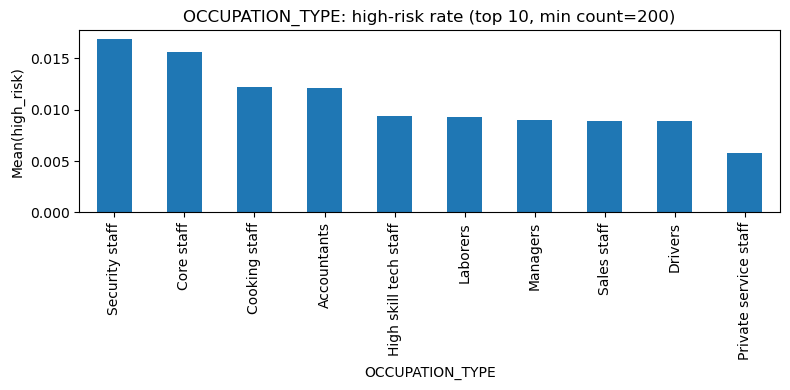


Top FLAG_MOBIL categories by high-risk rate (min count=200):


,mean,count
FLAG_MOBIL,,
1,0.010506,36457


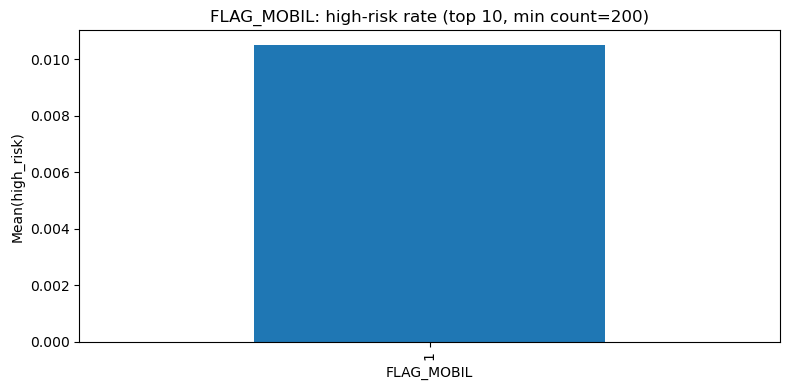


Top CODE_GENDER categories by high-risk rate (min count=200):


,mean,count
CODE_GENDER,,
M,0.012306,12027
F,0.009619,24430


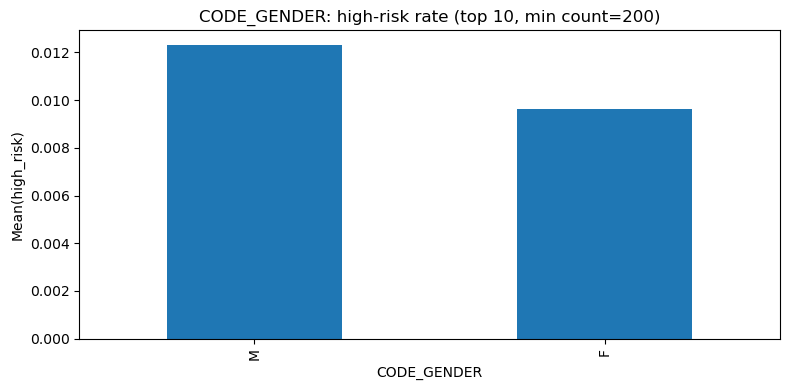


Top NAME_EDUCATION_TYPE categories by high-risk rate (min count=200):


,mean,count
NAME_EDUCATION_TYPE,,
Lower secondary,0.024064,374
Incomplete higher,0.014894,1410
Higher education,0.011963,9864
Secondary / secondary special,0.009485,24777


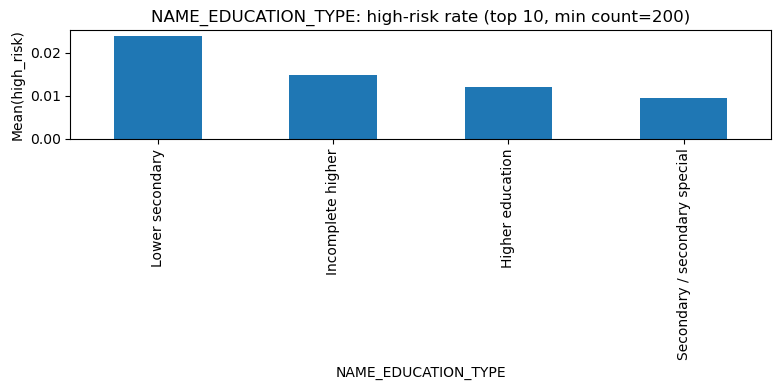


Top NAME_FAMILY_STATUS categories by high-risk rate (min count=200):


,mean,count
NAME_FAMILY_STATUS,,
Widow,0.017624,1532
Single / not married,0.014082,4829
Separated,0.012839,2103
Married,0.009821,25048
Civil marriage,0.005093,2945


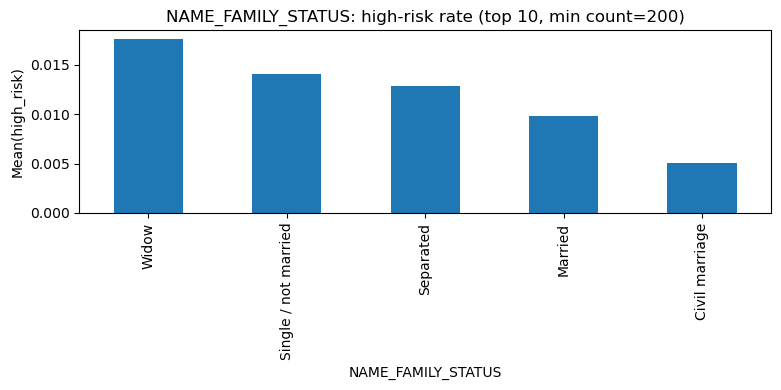


Top NAME_HOUSING_TYPE categories by high-risk rate (min count=200):


,mean,count
NAME_HOUSING_TYPE,,
Municipal apartment,0.023050,1128
Office apartment,0.019084,262
Rented apartment,0.010435,575
House / apartment,0.010016,32548
With parents,0.009572,1776


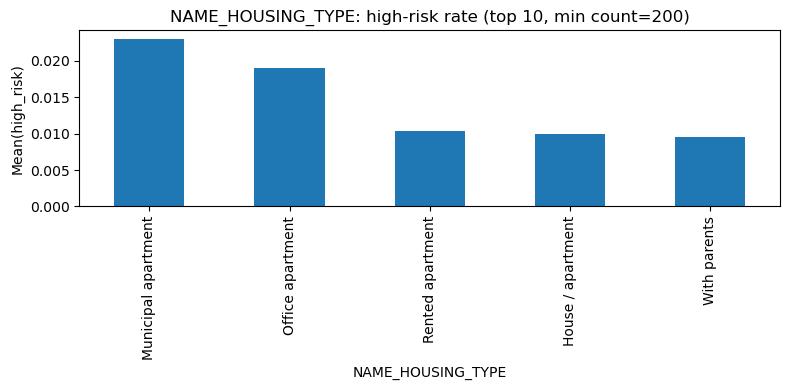

In [10]:
# Checks which categorical columns contain the more high risk clients by looking at the mean of 1s in 0s and 1s.
# So the mean will show you the percent of the count which are high risk
MIN_COUNT = 200 # must have at least 200 in the column to see 

for col in categorical_cols:
    tab = merged.groupby(col)["high_risk"].agg(["mean","count"]).sort_values("mean", ascending=False)
    tab = tab[tab["count"] >= MIN_COUNT]

    print(f"\nTop {col} categories by high-risk rate (min count={MIN_COUNT}):")
    display(tab.head(10))

    plt.figure(figsize=(8,4))
    tab.head(10)["mean"].plot(kind="bar")
    plt.title(f"{col}: high-risk rate (top 10, min count={MIN_COUNT})")
    plt.ylabel("Mean(high_risk)")
    plt.tight_layout()
    plt.show()